In [1]:
import librosa
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
from IPython.display import Audio, display

import sys
sys.path.append('../ASC_AED_JoinTask/Datasets/')
sys.path.append('../ASC_AED_JoinTask/models/')
import datasets
import models
import audio_utils

SAMPLE_RATE = 32000
FMAX = 16000
FMIN = 0
N_MELS = 64
HOP_LEN = 500
N_FFT = 1024

In [2]:
fft_freq = librosa.fft_frequencies(sr=SAMPLE_RATE, n_fft=N_FFT)
mel_freq = librosa.mel_frequencies(n_mels=N_MELS, fmax=FMAX)

In [3]:
model = models.Cnn_9layers_AvgPooling(10, 'logsoftmax')
model_path = '../ASC_AED_JoinTask/models/state_dicts/ASC_scapper_Cnn9_64mel_10epochs.pt'
model.load_state_dict(torch.load(model_path))

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [4]:
scapper_test_csv = '../ASC_AED_JoinTask/predictions/scapper_preds/ASC_scapper_Cnn9_64mel_10epochs.csv'
scapper_df = pd.read_csv(scapper_test_csv)
scapper_scenes = list(scapper_df['acoustic_scene_label'].unique())

In [63]:
import panns_inference
from panns_inference import AudioTagging, SoundEventDetection
from panns_inference import labels as labs

at = AudioTagging(checkpoint_path='../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth', device='cuda:1')

def get_event_list(clipwise_output):
    # With the slicing, we are reversing the sorted index to get the descending order of event probs.
    sorted_indexes = np.argsort(clipwise_output)[::-1]
    event_list = []

    # Creating a list of events with more than 0.05 prob
    for i in range(0, len(sorted_indexes)):
        event_prob = clipwise_output[sorted_indexes[i]]
        if event_prob > 0.05:
            event_list.append(np.array(labs)[sorted_indexes[i]])
    
    return event_list


def get_panns_events_list(audio):
    
    audio = audio[None, :]
    clipwise_op, embedding = at.inference(audio)

    event_list = get_event_list(clipwise_op[0])
    return event_list

Checkpoint path: ../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth
Using CPU.


In [5]:
def generate_log_mel(wav, SAMPLE_RATE):
    mel_S = librosa.feature.melspectrogram(y=wav, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LEN)
    log_mel = librosa.power_to_db(mel_S, ref=np.max)
    return log_mel

def show_log_mel(wav, SAMPLE_RATE):
    log_mel = generate_log_mel(wav, SAMPLE_RATE)

    librosa.display.specshow(log_mel, sr=SAMPLE_RATE, x_axis='time', y_axis='mel', win_length=N_FFT, hop_length=HOP_LEN, fmax=FMAX, fmin=FMIN)
    plt.show()

def ablate_features(index, audio):

    audio_stft = librosa.stft(audio, n_fft=N_FFT)
    low_index = index*4
    high_index = low_index+3
    l0 = fft_freq>=mel_freq[low_index]
    l1 = fft_freq<=mel_freq[high_index]

    for i in range(len(l0)):
        if l0[i] & l1[i]:
            audio_stft[i,:] = np.complex64(0+0j)

    y_new = librosa.istft(audio_stft, n_fft=N_FFT)
    return y_new

def run_loop(audio_fname, model):
    preds_list = []
    audio, sr = librosa.load(audio_fname, sr=SAMPLE_RATE)
    
    for i in range(16):
        y_new = ablate_features(i, audio)
        log_mel = torch.from_numpy(generate_log_mel(y_new, SAMPLE_RATE)).unsqueeze(0)

        model.eval()
        with torch.no_grad():
            pred = model(log_mel.to(device))
            pred = scapper_scenes[torch.argmax(torch.sigmoid(pred.cpu()))]
        preds_list.append(pred)
    return preds_list

In [55]:
sample_file = '../audioData/sythenticSoundscenes/test/tube1_0.wav'
#sample_file = '/work/dpandya/giggityGit/audioData/TUTUrban2018/developmentDataset/TUT-urban-acoustic-scenes-2018-development/audio/bus-paris-26-911-a.wav'
#wav, sr = librosa.load(sample_file, sr=SAMPLE_RATE)
#run_loop(sample_file, model)


In [6]:
true_preds = scapper_df[scapper_df['acoustic_scene_label'] == scapper_df['preds']]

feat_ablation_preds = {i:[] for i in scapper_scenes}
random_files = []

for i in scapper_scenes:
    random.seed(42)
    random_files.append(random.sample(true_preds[true_preds['acoustic_scene_label'] == i]['audio_fileNames'].tolist(), 30))

for i in range(len(scapper_scenes)):
    for j in random_files[i]:
        feat_ablation_preds[scapper_scenes[i]].append(run_loop('../audioData/sythenticSoundscenes/test/'+j, model))



In [7]:
feat_ablation = {i:[0 for j in range(16)] for i in scapper_scenes}

for i in scapper_scenes:
    for j in range(len(feat_ablation_preds[i])):
        for k in range(len(feat_ablation_preds[i][j])):
            if i != feat_ablation_preds[i][j][k]:
                feat_ablation[i][k] += 1

<Axes: >

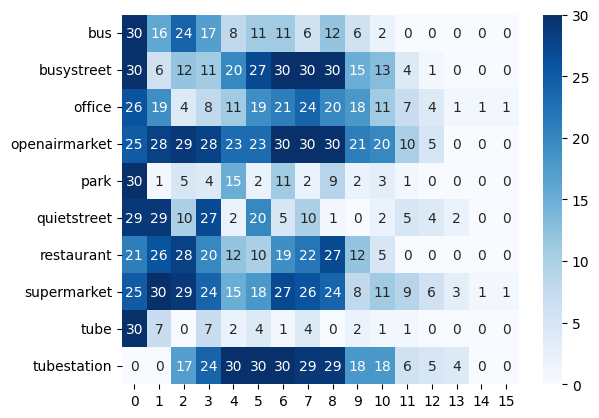

In [8]:
sns.heatmap(pd.DataFrame(feat_ablation).transpose(), fmt='d', annot=True, cmap='Blues', yticklabels=scapper_scenes)

In [16]:
feat_ablation_indices = {}
for i in scapper_scenes:
    feat_ablation_indices[i] = [j for j in range(len(feat_ablation[i])) if feat_ablation[i][j] >= 15]


In [37]:
scene_events_df = pd.DataFrame()
scene_labs_forDF = []
rand_fnames_forDF = []
feat_ablation_temp = []


for i in range(len(scapper_scenes)):
    for j in range(len(random_files[i])):
        #print(scapper_scenes[i], j)
        scene_labs_forDF.append(scapper_scenes[i])
        rand_fnames_forDF.append('../audioData/sythenticSoundscenes/test/'+random_files[i][j])
        feat_ablation_temp.append(feat_ablation_preds[scapper_scenes[i]][j])
        #print(feat_ablation_preds[scapper_scenes[i]][j])

scene_events_df['acoustic_scene_label'] = scene_labs_forDF
scene_events_df['audio_fileNames'] = rand_fnames_forDF
scene_events_df['feat_ablation_preds'] = feat_ablation_temp

In [66]:
feat_ablation_indices

{'bus': [0, 1, 2, 3],
 'busystreet': [0, 4, 5, 6, 7, 8, 9],
 'office': [0, 1, 5, 6, 7, 8, 9],
 'openairmarket': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'park': [0, 4],
 'quietstreet': [0, 1, 3, 5],
 'restaurant': [0, 1, 2, 3, 6, 7, 8],
 'supermarket': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'tube': [0],
 'tubestation': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

In [69]:
pure_events_list = []
feat_ablation_events_list = []


for i, row in scene_events_df.iterrows():
    local_feat_ablation_events = []
    audio, sr = librosa.load(row['audio_fileNames'], sr=SAMPLE_RATE)
    pure_events_list.append(get_panns_events_list(audio))

    for j in feat_ablation_indices[row['acoustic_scene_label']]:
        y_new = ablate_features(j, audio)
        local_feat_ablation_events.append(get_panns_events_list(y_new))

    feat_ablation_events_list.append(local_feat_ablation_events)

In [73]:
scene_events_df['scene_events'] = pure_events_list
scene_events_df['feat_ablation_events'] = feat_ablation_events_list

In [85]:
scene_events_df.to_csv('feat_ablation_sceneXevents.csv', index=False)

In [84]:
ind = 0

for i in scene_events_df['feat_ablation_events'].iloc[ind]:
    for j in scene_events_df['scene_events'].iloc[ind]:
        if j not in i:
            print(j)

Throat clearing
Belly laugh
Throat clearing
Belly laugh


In [65]:
audio, sr = librosa.load(scene_events_df['audio_fileNames'].iloc[-15], sr=SAMPLE_RATE)
#audio, sr = librosa.load(sample_file, sr=SAMPLE_RATE)
print(get_panns_events_list(audio))

['Speech', 'Music', 'Chatter']


In [19]:
for i in random_files:
    print(i)

['bus1_upshift_7.wav', 'bus10_downshift_2.wav', 'bus4_upshift_0.wav', 'bus4_5.wav', 'bus3_upshift_4.wav', 'bus2_downshift_1.wav', 'bus1_upshift_2.wav', 'bus9_9.wav', 'bus1_downshift_4.wav', 'bus7_6.wav']
['busystreet1_upshift_7.wav', 'busystreet10_downshift_2.wav', 'busystreet4_upshift_0.wav', 'busystreet4_5.wav', 'busystreet3_upshift_4.wav', 'busystreet2_downshift_1.wav', 'busystreet1_upshift_2.wav', 'busystreet9_9.wav', 'busystreet1_downshift_4.wav', 'busystreet7_6.wav']
['office1_upshift_6.wav', 'office10_downshift_1.wav', 'office4_downshift_9.wav', 'office4_4.wav', 'office3_upshift_3.wav', 'office2_downshift_0.wav', 'office1_upshift_1.wav', 'office9_downshift_3.wav', 'office1_downshift_3.wav', 'office7_9.wav']
['openairmarket1_upshift_7.wav', 'openairmarket10_downshift_2.wav', 'openairmarket4_upshift_0.wav', 'openairmarket4_5.wav', 'openairmarket3_upshift_4.wav', 'openairmarket2_downshift_1.wav', 'openairmarket1_upshift_2.wav', 'openairmarket9_downshift_0.wav', 'openairmarket1_down

In [161]:

l0 = lib_freq>=mel_F[4]
l1 = lib_freq<=mel_F[7]

for i in range(len(l0)):
    if l0[i] & l1[i]:
        wav_stft[i,:] = np.complex64(0+0j)

y_new = librosa.istft(wav_stft, n_fft=N_FFT)